# Multiclass Semantic Segmentation using CamVid dataset

In [1]:
#Importing libraries
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

import os
import shutil
from tqdm import tqdm

import random
from sklearn.utils import shuffle
import tensorflow_addons as tfa
#import skimage

## Check system environment


In [2]:
print("Tensorflow version: ",tf.__version__)

print("Is GPU available: {}".format(tf.test.is_gpu_available()))

Tensorflow version:  2.1.0


W0319 01:49:40.686280 20632 deprecation.py:323] From <ipython-input-2-d03a236d2262>:3: is_gpu_available (from tensorflow.python.framework.test_util) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Is GPU available: True


## Data preparation - Import data, clean and creating structured directory


## Important variables to be set before running the notebook

In [3]:

# Set DEBUG level.  When debug flag is on, additional results and print statements are shown in the results
DEBUG = True

# Do you want to train model, or load a previously saved model?
flag_train_model = True # Load saved model, or train new

flag_use_weighted_loss_fcn = False


### Image directory location and the input image size. 

In [4]:
img_dir = "..\data\CamSeq01"

#Required image dimensions
IMG_HEIGHT = 256
IMG_WIDTH = 256
INPUT_CHANNELS =3

# training_batch_size = 5 

## Reading frames and masks
. Mask file names end with "_L.png"

In [5]:
def separate_data_from_labels(img_dir):
    '''
    '''
#     regexp_path = str(os.path.join(img_dir,"*"))
#     list_ds = tf.data.Dataset.list_files(regexp_path)    
#     for f in list_ds.take(5):
#         print(f.numpy())

    #Get all the file names list from the directory
    all_file_list = [f for f in os.listdir(img_dir) if f.endswith(".png")]
    print("Total PNG files in the folder: {}".format(len(all_file_list)))
    
    # Get actual images
    frame_files_list =[os.path.join(img_dir,f) for f in all_file_list if "_L" not in f]

    image_count = len(frame_files_list)
    # Get masks - Get the files with _L in their name
    mask_files_list =[os.path.join(img_dir,f) for f in all_file_list if "_L" in f]
    
    print("Trainable frames in the folder: {}".format(image_count))
    print("Mask images in the folder: {}".format(len(mask_files_list)))

#     data_list_ds = tf.data.Dataset.from_tensor_slices(img_files_list)
#     mask_list_ds = tf.data.Dataset.from_tensor_slices(mask_files_list)

    
    return frame_files_list, mask_files_list

# read_images(img_dir)
frame_files_list, mask_files_list = separate_data_from_labels(img_dir)


Total PNG files in the folder: 202
Trainable frames in the folder: 101
Mask images in the folder: 101


In [6]:
# Make the train validation folder

folders = ['train_frames\\frames', 'train_masks\\masks', 'val_frames\\frames', 'val_masks\\masks']

for folder in folders:
    try:
        os.makedirs(os.path.join(img_dir,folder))
    except Exception as ex:
        print(ex)
        

train_frames_folder = os.path.join(img_dir,'train_frames')
train_masks_folder = os.path.join(img_dir,'train_masks')


validation_frames_folder = os.path.join(img_dir,'val_frames')
validation_masks_folder = os.path.join(img_dir,'val_masks')
    
        
    

[WinError 183] Cannot create a file when that file already exists: '..\\data\\CamSeq01\\train_frames\\frames'
[WinError 183] Cannot create a file when that file already exists: '..\\data\\CamSeq01\\train_masks\\masks'
[WinError 183] Cannot create a file when that file already exists: '..\\data\\CamSeq01\\val_frames\\frames'
[WinError 183] Cannot create a file when that file already exists: '..\\data\\CamSeq01\\val_masks\\masks'


### Separate out the files into folders

In [7]:
if len(os.listdir(os.path.join(train_frames_folder,'frames')))==0:

    validation_fraction = 0.3
    total_samples = len(frame_files_list)

    num_validation_samples = int(np.ceil(validation_fraction*total_samples))
    num_training_samples = total_samples - num_validation_samples
    print("Total samples: {}".format(total_samples))

    # Get random indices for separating the validation samples

    idx_range = np.arange(total_samples)
    shuffled_idx = shuffle(idx_range, random_state=33)
    print(shuffled_idx)
    
    # print(shuffled_idx)
    idx_validation = shuffled_idx[:num_validation_samples]
    idx_train = shuffled_idx[num_validation_samples:]

    # Move the validation and trainng samples to the correct folders

    # Move training frames
    [shutil.copy(frame_files_list[i], os.path.join(train_frames_folder,'frames',os.path.split(frame_files_list[i])[-1])) for i in idx_train]

    # Move training masks
    [shutil.copy(mask_files_list[i], os.path.join(train_masks_folder,'masks',os.path.split(mask_files_list[i])[-1])) for i in idx_train]


    # Move validation frames
    [shutil.copy(frame_files_list[i], os.path.join(validation_frames_folder,'frames',os.path.split(frame_files_list[i])[-1])) for i in idx_validation]

    # Move validation masks
    [shutil.copy(mask_files_list[i], os.path.join(validation_masks_folder,'masks',os.path.split(mask_files_list[i])[-1])) for i in idx_validation]

    print("File copying complete")
    
else:
    print("Training / validation folders already exists, not copying files")
    num_training_samples = len(os.listdir(os.path.join(train_frames_folder,'frames')))
    num_validation_samples = len(os.listdir(os.path.join(validation_frames_folder,'frames')))

idx_range = np.arange(100)
shuffled_idx = shuffle(idx_range, random_state=33)
# print(shuffled_idx)

print("Num training samples: {}".format(num_training_samples))
print("Num validation samples: {}".format(num_validation_samples))

asd = os.listdir(os.path.join(train_frames_folder,'frames'))
asd = os.path.join(train_frames_folder,'frames',asd[0])

print(asd)
orig_img_height = plt.imread(asd).shape[0]
orig_img_width = plt.imread(asd).shape[1]

print("Shape of image")
print("orig_img_height: {}, orig_img_width: {}".format(orig_img_height,orig_img_width))
      

Training / validation folders already exists, not copying files
Num training samples: 70
Num validation samples: 31
..\data\CamSeq01\train_frames\frames\0016E5_07959.png
Shape of image
orig_img_height: 720, orig_img_width: 960


### Extract the labels for each class
The masks have RGB triplets for each class. I need to modify this into class ids


In [8]:
labels_fname = os.path.join(img_dir,'label_colors.txt')

dict_idx_class = {}
dict_idx_rgb =   {}

with open(labels_fname) as fp:
    for cnt,line in enumerate(fp):
        
        # Separate componenets of each line. The name is separate from the rgb triplet by a tab
        x =line.split("\t")
        rgb_value = x[0]
        
        # Need the RGB in int not as a string
        rgb_value = tuple(int(i) for i in rgb_value.split(" "))

        # Extract the class names
        class_name = x[-1].rstrip()
        
#         print("Line number: {}, class: {}, rgb triplet: {}".format(cnt,class_name,rgb_value))
        
        #Create a dictionary of idx-name pairs
        dict_idx_class[cnt]=class_name
        dict_idx_rgb[cnt]=rgb_value

n_classes = len(dict_idx_class)
print("Number of classes in the image: {}".format(n_classes))


Number of classes in the image: 32


In [9]:
print("Idx to class dictionary:")
dict_idx_class


Idx to class dictionary:


{0: 'Animal',
 1: 'Archway',
 2: 'Bicyclist',
 3: 'Bridge',
 4: 'Building',
 5: 'Car',
 6: 'CartLuggagePram',
 7: 'Child',
 8: 'Column_Pole',
 9: 'Fence',
 10: 'LaneMkgsDriv',
 11: 'LaneMkgsNonDriv',
 12: 'Misc_Text',
 13: 'MotorcycleScooter',
 14: 'OtherMoving',
 15: 'ParkingBlock',
 16: 'Pedestrian',
 17: 'Road',
 18: 'RoadShoulder',
 19: 'Sidewalk',
 20: 'SignSymbol',
 21: 'Sky',
 22: 'SUVPickupTruck',
 23: 'TrafficCone',
 24: 'TrafficLight',
 25: 'Train',
 26: 'Tree',
 27: 'Truck_Bus',
 28: 'Tunnel',
 29: 'VegetationMisc',
 30: 'Void',
 31: 'Wall'}

In [10]:
print("Idx to rgb triplet dictionary:")
dict_idx_rgb


Idx to rgb triplet dictionary:


{0: (64, 128, 64),
 1: (192, 0, 128),
 2: (0, 128, 192),
 3: (0, 128, 64),
 4: (128, 0, 0),
 5: (64, 0, 128),
 6: (64, 0, 192),
 7: (192, 128, 64),
 8: (192, 192, 128),
 9: (64, 64, 128),
 10: (128, 0, 192),
 11: (192, 0, 64),
 12: (128, 128, 64),
 13: (192, 0, 192),
 14: (128, 64, 64),
 15: (64, 192, 128),
 16: (64, 64, 0),
 17: (128, 64, 128),
 18: (128, 128, 192),
 19: (0, 0, 192),
 20: (192, 128, 128),
 21: (128, 128, 128),
 22: (64, 128, 192),
 23: (0, 0, 64),
 24: (0, 64, 64),
 25: (192, 64, 128),
 26: (128, 128, 0),
 27: (192, 128, 192),
 28: (64, 0, 64),
 29: (192, 192, 0),
 30: (0, 0, 0),
 31: (64, 192, 0)}

### Create functions for converting onehot vectors into the colormap and colormap into onehot vectors 

In [11]:
def rgb_to_onehot(rgb_image,dict_idx_rgb):
    '''
    Take a rgb label image and return a onehot image as input with h x w x n_classes
    '''
    
    rgb_image =rgb_image.astype(np.int)
    # Create empty array of size m x n x n_classes
    onehot_image = np.zeros((rgb_image.shape[0],rgb_image.shape[1],n_classes),dtype=np.uint8)

    # assign True depending on the rgb triplet
    for idx in range(n_classes):
        onehot_image[:,:,idx] = np.all(rgb_image.reshape(-1,3) == dict_idx_rgb[idx],axis=1).reshape(rgb_image.shape[:2])
    
#     print(onehot_image[:,:,4])        
#     print(onehot_image.shape)    
    return onehot_image


def onehot_to_rgb(onehot_image,dict_idx_rgb):
    '''
    Take a onehot image as input with h x w x n_classes, and return a rgb image
    '''
    
    #Get 1 channel image
    onehot_single_channel = np.argmax(onehot_image,axis=-1) 
    
    rgb_image = np.zeros((onehot_image.shape[0],onehot_image.shape[1],3),dtype=np.uint8)

    for i in dict_idx_rgb.keys():
#         rgb_image[onehot_single_channel==i] == dict_idx_rgb[i]

        rgb_image[onehot_single_channel==i] = dict_idx_rgb[i]

#     print(np.max(np.argmax(onehot_image,axis=2)))
#     print(onehot_single_channel)

    return rgb_image 

def rgb_to_class_id(rgb_image,dict_idx_rgb, dict_idx_class):
    '''
    Take a rgb label image and return a class id image of shape  h x w
    '''
    rgb_image =rgb_image.astype(np.int)
    # Create empty array of size m x n x n_classes
    class_id_image = np.zeros((rgb_image.shape[0],rgb_image.shape[1]),dtype=np.uint8)

    # assign True depending on the rgb triplet
    for idx in range(n_classes):
        class_id_idx = np.all(rgb_image.reshape(-1,3) == dict_idx_rgb[idx],axis=1).reshape(rgb_image.shape[:2])
        class_id_image[class_id_idx] = idx
        
#     print(onehot_image[:,:,4])        
#     print(onehot_image.shape)    
    return class_id_image

# out = rgb_to_onehot(mask_array[0], dict_idx_rgb)    
# out = onehot_to_rgb(np.zeros((256,256,32)), dict_idx_rgb)    
# plt.imshow(out[:,:,4])


### Use the ImageDataGenerators for creating batches of data for training and validation

Note that, in this case, I can't use the keras iamge generator as is. The mask image is in rgb triplets.
This triplet data has to be converted into class idx/ onehot matrices before being sent to the training model.


In [12]:
frame_gen_args = dict(rescale=1/255.0)
mask_gen_args = dict()

train_frame_generator = keras.preprocessing.image.ImageDataGenerator(**frame_gen_args)
train_mask_generator = keras.preprocessing.image.ImageDataGenerator(**mask_gen_args)

validate_frame_generator = keras.preprocessing.image.ImageDataGenerator(**frame_gen_args)
validate_mask_generator = keras.preprocessing.image.ImageDataGenerator(**mask_gen_args)


### Create the custom image data generator

In [13]:
# max_tx=10
# max_ty=20
# batch_size=3

# tx = tf.random.uniform((batch_size,1),minval=-max_tx, maxval=max_tx)
# ty = tf.random.uniform((batch_size,1),minval=-max_ty, maxval=max_ty)

# disp_xy = tf.random.uniform((batch_size,2),minval=-max_tx, maxval=max_tx)

# # out =np.hstack((tx,ty))
# # out = np.array([tx,ty])
# print(disp_xy.numpy())
# # print(tx.numpy())
# # print(ty)

In [14]:
def crop_images_to_size(current_batch_frames, current_batch_masks, batch_size):
    '''
    Input large array of large image size,
    returns image with target size cropped from this large image
    '''
    
    max_var_height = int(current_batch_frames.shape[1]/2)#  - IMG_HEIGHT - 1
    max_var_width = int(current_batch_frames.shape[2]/2 )# - IMG_WIDTH - 1
    
    allowed_max_height =  current_batch_frames.shape[1] - max_var_height
    allowed_max_width =  current_batch_frames.shape[2] - max_var_width
    
#     print("current_batch_frames.shape[1]",current_batch_frames.shape[1])
#     print("current_batch_frames.shape[2]",current_batch_frames.shape[2])
    
    tgt_offset_height = tf.random.uniform(shape=(batch_size,),minval=0,maxval= max_var_height,dtype=tf.int32)
    tgt_offset_width  = tf.random.uniform(shape=(batch_size,),minval=0,maxval= max_var_width,dtype=tf.int32)


    allowed_height_based_on_offset = tf.random.uniform(shape=(batch_size,),minval=200,maxval= allowed_max_height,dtype=tf.int32)
    allowed_width_based_on_offset = tf.random.uniform(shape=(batch_size,),minval=200,maxval= allowed_max_width,dtype=tf.int32)
    
#     print("tgt_offset_height",tgt_offset_height)
#     print("tgt_offset_width",tgt_offset_width)
#     print("allowed_height_based_on_offset",allowed_height_based_on_offset)
#     print("allowed_width_based_on_offset",allowed_width_based_on_offset)
    
#     print(tgt_offset_height + allowed_height_based_on_offset)
#     print(tgt_offset_width + allowed_width_based_on_offset)

#     print("current_batch_frames.shape",current_batch_frames.shape)
#     print("current_batch_masks.shape",current_batch_masks.shape)

    # Create the empty array
    # Create the out array for 1 hot encoding
    out_current_batch_frames = np.zeros((batch_size,IMG_HEIGHT,IMG_WIDTH,current_batch_frames.shape[-1]),dtype=np.float32)
    out_current_batch_masks = np.zeros((batch_size,IMG_HEIGHT,IMG_WIDTH,current_batch_frames.shape[-1]),dtype=np.float32)
      # Create the out array for 1 hot encoding
    out_onehot_batch_masks = np.zeros((batch_size,IMG_HEIGHT,IMG_WIDTH,n_classes),dtype=np.float32)

    # Crop the frame and mask to the correct size
    for i in range(batch_size):
        
#         # The crops shouldnt be the 256 x 256. See if you can make random size and then resize them to the right output shape
#         allowed_height_based_on_offset = tf.random.uniform(shape=(1,),minval=0,maxval= orig_img_height - tgt_offset_height[i]-1,dtype=tf.int32)[0]
#         allowed_width_based_on_offset = tf.random.uniform(shape=(1,),minval=0,maxval= orig_img_width - tgt_offset_width[i]-1,dtype=tf.int32)[0]

#         allowed_height_based_on_offset = np.min(np.max(100,allowed_height_based_on_offset),max_var_height*2)
#         allowed_width_based_on_offset = np.min(np.max(100,allowed_width_based_on_offset),max_var_width*2)
#         print("allowed_height_based_on_offset",allowed_height_based_on_offset)
#         print("allowed_width_based_on_offset",allowed_width_based_on_offset)
        
#         print("crop fcn, batch_size={}, i={} ".format(batch_size,i))
        temp = tf.image.crop_to_bounding_box(current_batch_frames[i],
                                                                offset_height=tgt_offset_height[i],
                                                                offset_width=tgt_offset_width[i],
                                                                target_height=allowed_height_based_on_offset[i],
                                                                target_width=allowed_width_based_on_offset[i])
        out_current_batch_frames[i] = tf.image.resize(temp,(IMG_HEIGHT,IMG_WIDTH))

        temp2 = tf.image.crop_to_bounding_box(current_batch_masks[i],
                                                                offset_height=tgt_offset_height[i],
                                                                offset_width=tgt_offset_width[i],
                                                                target_height=allowed_height_based_on_offset[i],
                                                                target_width=allowed_width_based_on_offset[i])
        
        out_current_batch_masks[i] =tf.image.resize(temp2,(IMG_HEIGHT,IMG_WIDTH))

#     print("out_onehot_batch_masks.shape: ", out_onehot_batch_masks.shape)
#     print("out_current_batch_frames.shape: ", out_current_batch_frames.shape)
#     print("out_current_batch_masks.shape: ", out_current_batch_masks.shape)

    return out_current_batch_frames, out_current_batch_masks, out_onehot_batch_masks

    

In [15]:
def TrainingDataGenerator(seed=1, batch_size=5):
    
    # Use the ImageGenerator syntax to get data from directory
    print("In TrainingDataGenerator ")
    flag_first_time = True
    
    if(flag_first_time):
        print("Initializing  TrainingDataGenerator ")
        seed =np.random.randint(0,1e3)

        train_frames_data = train_frame_generator.flow_from_directory(train_frames_folder,
                                                              seed=seed,
                                                              batch_size=batch_size,
                                                              target_size=(orig_img_height, orig_img_width))


        train_masks_data = train_mask_generator.flow_from_directory(train_masks_folder,
                                                              seed=seed,
                                                              batch_size=batch_size,
                                                              target_size=(orig_img_height, orig_img_width))

        flag_first_time = False

#     current_batch_frames = train_frames_data.next()
#     current_batch_masks  = train_masks_data.next()

    while True:
        
        current_batch_frames = next(train_frames_data)[0]
        current_batch_masks  = next(train_masks_data)[0]

#         print("current_batch_frames.shape: ", current_batch_frames.shape)
#         print("current_batch_masks.shape: ", current_batch_masks.shape)

        if(current_batch_frames.shape[0]< batch_size):
#             print("TrainingDataGenerator - current_batch smaller than required. Resetting generator")
            train_frames_data.reset()
            train_masks_data.reset()
            current_batch_frames = next(train_frames_data)[0]
            current_batch_masks  = next(train_masks_data)[0]
#             print("After reset, current_batch_frames.shape: ", current_batch_frames.shape)
#             print("After reset, current_batch_masks.shape: ", current_batch_masks.shape)

        out_current_batch_frames, out_current_batch_masks, out_onehot_batch_masks = \
        crop_images_to_size(current_batch_frames,current_batch_masks,batch_size)
        
        # Create the onehot mask
        for i in range(batch_size):
            out_onehot_batch_masks[i] = rgb_to_onehot(out_current_batch_masks[i],dict_idx_rgb)


        # Data Augmentation        
        for i in range(batch_size):

            # Data augmentation left right flip
            if tf.random.uniform(()) > 0.5:
                out_current_batch_frames[i] = tf.image.flip_left_right(out_current_batch_frames[i])
                out_onehot_batch_masks[i] = tf.image.flip_left_right(out_onehot_batch_masks[i])

#             # Data augmentation rotate
#             if tf.random.uniform(()) > 0.5:

#                 max_rot_angle_deg = 20 # +- x
#                 rotate_deg = tf.random.uniform(()) * max_rot_angle_deg - max_rot_angle_deg/2
#                 rotate_rads = rotate_deg*(np.pi/180)
# #                 print(rotate_deg)
#                 out_current_batch_frames[i] = tfa.image.rotate(out_current_batch_frames[i], rotate_rads)
#                 out_onehot_batch_masks[i] = tfa.image.rotate(out_onehot_batch_masks[i], rotate_rads)

#             # Data augmentation shift
#             if tf.random.uniform(()) > 0.5:
#                 max_tx= 20 #px
#                 disp_xy = tf.random.uniform((1,2),minval=-max_tx, maxval=max_tx)
#                 out_current_batch_frames[i] =tfa.image.translate(out_current_batch_frames[i],disp_xy.numpy())
#                 out_onehot_batch_masks[i] = tfa.image.translate(out_onehot_batch_masks[i],disp_xy.numpy())
                
        yield (out_current_batch_frames, out_onehot_batch_masks)


def ValidationDataGenerator(seed=1, batch_size=5):
    
    # Use the ImageGenerator syntax to get data from directory
    print("In ValidationDataGenerator ")
    flag_first_time_validation_gen =True
        
    if(flag_first_time_validation_gen):            
        print("Initializing  ValidationDataGenerator ")
        seed =np.random.randint(0,1e3)

        valid_frames_data = validate_frame_generator.flow_from_directory(validation_frames_folder,
                                                              seed=seed,
    #                                                           shuffle=False,
                                                              batch_size=batch_size,
                                                              target_size=(orig_img_height, orig_img_width))


        valid_masks_data = validate_mask_generator.flow_from_directory(validation_masks_folder,
                                                              seed=seed,
    #                                                           shuffle=False,
                                                              batch_size=batch_size,
                                                              target_size=(orig_img_height, orig_img_width))


        flag_first_time_validation_gen = False
        #From this batch, modify the mask so that the n x height x width x 3 data is transformed into n x height x width x n_classes
        # Create the generator
        # Extract a batch of data
        
#     current_batch_frames = valid_frames_data.next()
#     current_batch_masks  = valid_masks_data.next()
    while True:
#         # Extract a batch of data
        current_batch_frames = valid_frames_data.next()[0]
        current_batch_masks  = valid_masks_data.next()[0]
#         print("current_batch_frames.shape: ", current_batch_frames.shape)
#         print("current_batch_masks.shape: ", current_batch_masks.shape)
        
        if(current_batch_frames.shape[0]< batch_size):
#             print("ValidationDataGenerator - current_batch smaller than required. Resetting generator")
            valid_frames_data.reset()
            valid_masks_data.reset()
            current_batch_frames = valid_frames_data.next()[0]
            current_batch_masks  = valid_masks_data.next()[0]
        #             print("After reset, current_batch_frames.shape: ", current_batch_frames.shape)
        #             print("After reset, current_batch_masks.shape: ", current_batch_masks.shape)

        
        out_current_batch_frames, out_current_batch_masks, out_onehot_batch_masks = \
        crop_images_to_size(current_batch_frames,current_batch_masks,batch_size)

#         print("out_onehot_batch_masks.shape: ", out_onehot_batch_masks.shape)
#         print("out_current_batch_frames.shape: ", out_current_batch_frames.shape)
#         print("out_current_batch_masks.shape: ", out_current_batch_masks.shape)

        for i in range(batch_size):
            out_onehot_batch_masks[i] = rgb_to_onehot(out_current_batch_masks[i],dict_idx_rgb)
        
#         print("onehot_batch_masks shape: ",onehot_batch_masks.shape)
#         yield (np.array(out_current_batch_frames),np.array(out_onehot_batch_masks))
        yield (out_current_batch_frames, out_onehot_batch_masks)
        

def TestDataGenerator(seed=1, batch_size=5):
    
    # Use the ImageGenerator syntax to get data from directory
    print("In TestDataGenerator ")
    flag_first_time_test_gen =True
        
    if(flag_first_time_test_gen):            
        print("Initializing TestDataGenerator ")
        seed =np.random.randint(0,1e3)

        valid_frames_data = validate_frame_generator.flow_from_directory(validation_frames_folder,
                                                              seed=seed,
    #                                                           shuffle=False,
                                                              batch_size=batch_size,
                                                              target_size=(IMG_HEIGHT,IMG_WIDTH))


        valid_masks_data = validate_mask_generator.flow_from_directory(validation_masks_folder,
                                                              seed=seed,
    #                                                           shuffle=False,
                                                              batch_size=batch_size,
                                                              target_size=(IMG_HEIGHT,IMG_WIDTH))


        flag_first_time_validation_gen = False
        #From this batch, modify the mask so that the n x height x width x 3 data is transformed into n x height x width x n_classes
        # Create the generator
        # Extract a batch of data
        
#     current_batch_frames = valid_frames_data.next()
#     current_batch_masks  = valid_masks_data.next()
    while True:
#         # Extract a batch of data
        current_batch_frames = valid_frames_data.next()[0]
        current_batch_masks  = valid_masks_data.next()[0]
        
#         out_current_batch_frames, out_current_batch_masks, out_onehot_batch_masks = \
#         crop_images_to_size(current_batch_frames,current_batch_masks,batch_size)
        
        out_current_batch_frames =current_batch_frames
        out_current_batch_masks =current_batch_masks
        
        out_onehot_batch_masks = np.zeros((batch_size,IMG_HEIGHT,IMG_WIDTH,n_classes),dtype=np.float32)

        print("out_onehot_batch_masks.shape: ", out_onehot_batch_masks.shape)
        print("out_current_batch_frames.shape: ", out_current_batch_frames.shape)
        print("out_current_batch_masks.shape: ", out_current_batch_masks.shape)

        for i in range(batch_size):
            out_onehot_batch_masks[i] = rgb_to_onehot(out_current_batch_masks[i],dict_idx_rgb)
        
#         print("onehot_batch_masks shape: ",onehot_batch_masks.shape)
        yield (out_current_batch_frames,out_onehot_batch_masks)
        

        
# Testing 

if DEBUG:
    
    print("Testing TrainingDataGenerator")
    m_batch = TrainingDataGenerator()
    test_batch = next(m_batch)
    im_array = test_batch[0]
    onehot_array = test_batch[1]

    print("im_array shape: {}, dtype: {}".format(im_array.shape, im_array.dtype))
    print("onehot_array shape:{}, dtype: {}".format(onehot_array.shape,onehot_array.dtype))

    print("\nTesting ValidationDataGenerator")

    m_batch = ValidationDataGenerator()


    test_batch = next(m_batch)
    im_array = test_batch[0]
    onehot_array = test_batch[1]

    print("im_array shape: ", im_array.shape)
    print("onehot_array shape: ", onehot_array.shape)



Testing TrainingDataGenerator
In TrainingDataGenerator 
Initializing  TrainingDataGenerator 
Found 70 images belonging to 1 classes.
Found 70 images belonging to 1 classes.
im_array shape: (5, 256, 256, 3), dtype: float32
onehot_array shape:(5, 256, 256, 32), dtype: float32

Testing ValidationDataGenerator
In ValidationDataGenerator 
Initializing  ValidationDataGenerator 
Found 31 images belonging to 1 classes.
Found 31 images belonging to 1 classes.
im_array shape:  (5, 256, 256, 3)
onehot_array shape:  (5, 256, 256, 32)


### Display some of the images  

<class 'generator'>
0 -getting new  batch
In TrainingDataGenerator 
Initializing  TrainingDataGenerator 
Found 70 images belonging to 1 classes.
Found 70 images belonging to 1 classes.
1 -getting new  batch
2 -getting new  batch


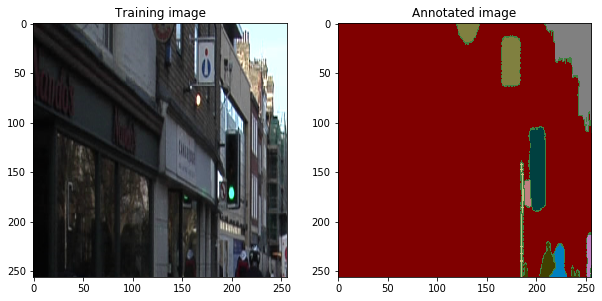

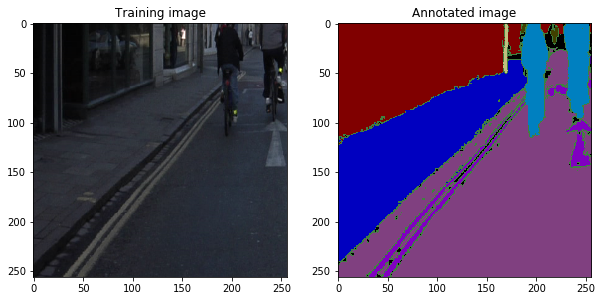

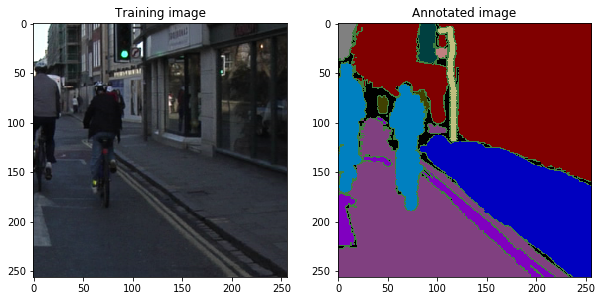

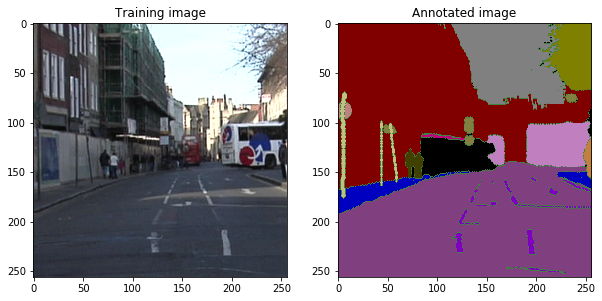

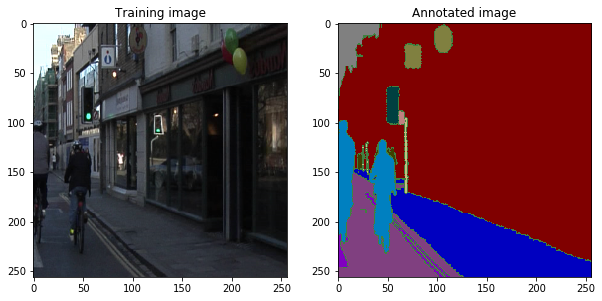

In [16]:
m_batch = TrainingDataGenerator(batch_size=5)
print(type(m_batch))
for j in range(3):
    print("{} -getting new  batch".format(j))
    test_batch = next(m_batch)

    im_array = test_batch[0]
    onehot_array = test_batch[1]

for i in range(im_array.shape[0]):
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(im_array[i])
    plt.title("Training image")
    plt.subplot(1,2,2)
    plt.imshow(onehot_to_rgb(onehot_array[i],dict_idx_rgb))
    plt.title("Annotated image")
    

<class 'generator'>
>>>>>>>>>> j=0 getting new  batch
In ValidationDataGenerator 
Initializing  ValidationDataGenerator 
Found 31 images belonging to 1 classes.
Found 31 images belonging to 1 classes.
im_array.shape:  (2, 256, 256, 3)
onehot_array.shape:  (2, 256, 256, 32)
>>>>>>>>>> j=1 getting new  batch
im_array.shape:  (2, 256, 256, 3)
onehot_array.shape:  (2, 256, 256, 32)


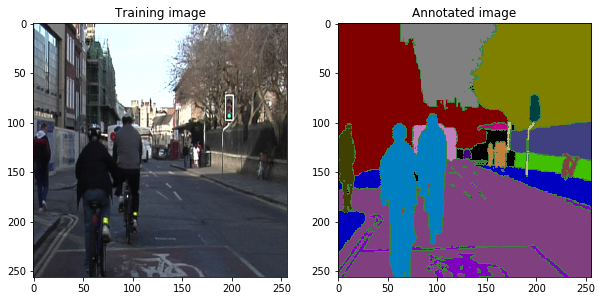

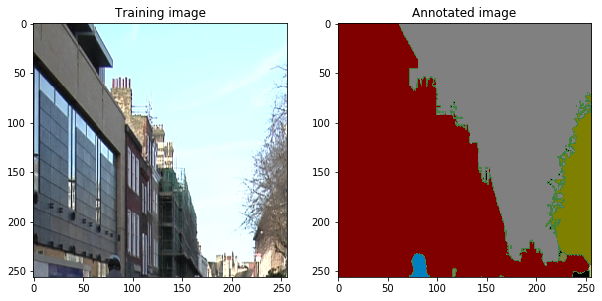

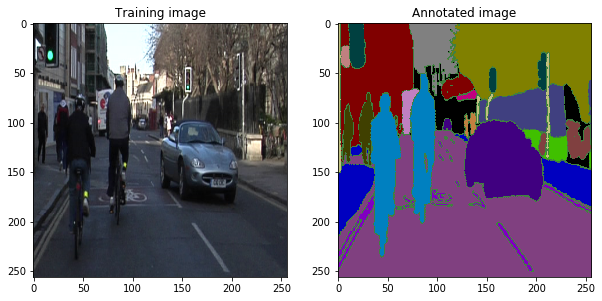

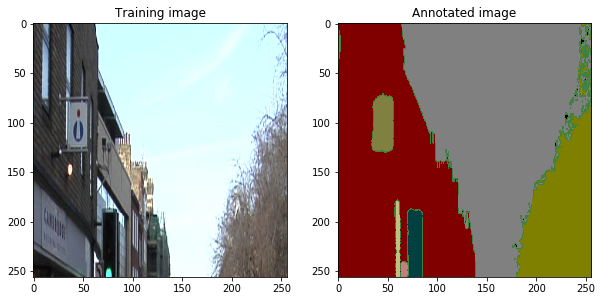

In [17]:
m_batch = ValidationDataGenerator(batch_size=2)
print(type(m_batch))
for j in range(2):
    print(">>>>>>>>>> j={} getting new  batch".format(j))
    test_batch = next(m_batch)

    im_array = test_batch[0]
    onehot_array = test_batch[1]
    
    print("im_array.shape: ", im_array.shape)
    print("onehot_array.shape: ", onehot_array.shape)

    for i in range(im_array.shape[0]):
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.imshow(im_array[i])
        plt.title("Training image")
        plt.subplot(1,2,2)
        plt.imshow(onehot_to_rgb(onehot_array[i],dict_idx_rgb))
        plt.title("Annotated image")


### Is there class imbalance?

Extract the pixels classifications


In [18]:
base_dir = os.path.join(train_masks_folder,'masks')

# fname = os.listdir(base_dir)[4]

hist_array=[]
for idx,fname in enumerate(tqdm(os.listdir(base_dir))):
    fpath = os.path.join(base_dir,fname)
#     print(fpath)
    # Using tf.io.read. matplotlib.pyplot.imread reads the image as floatss 0 - 1 , while I need the data as 0-255.
    # This is cleaner.

    img = tf.io.read_file(fpath)
    img = tf.io.decode_png(img)
    # print(img)
#     plt.imshow(img)
    
    class_image = rgb_to_class_id(img.numpy(),dict_idx_rgb, dict_idx_class)
    hist_array.append(np.reshape(class_image,(-1,)))

# Compbine all the values into a single vector
all_idx =np.array(hist_array).reshape(-1)






100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:34<00:00,  2.03it/s]


### Display the histogram of class label distribution 

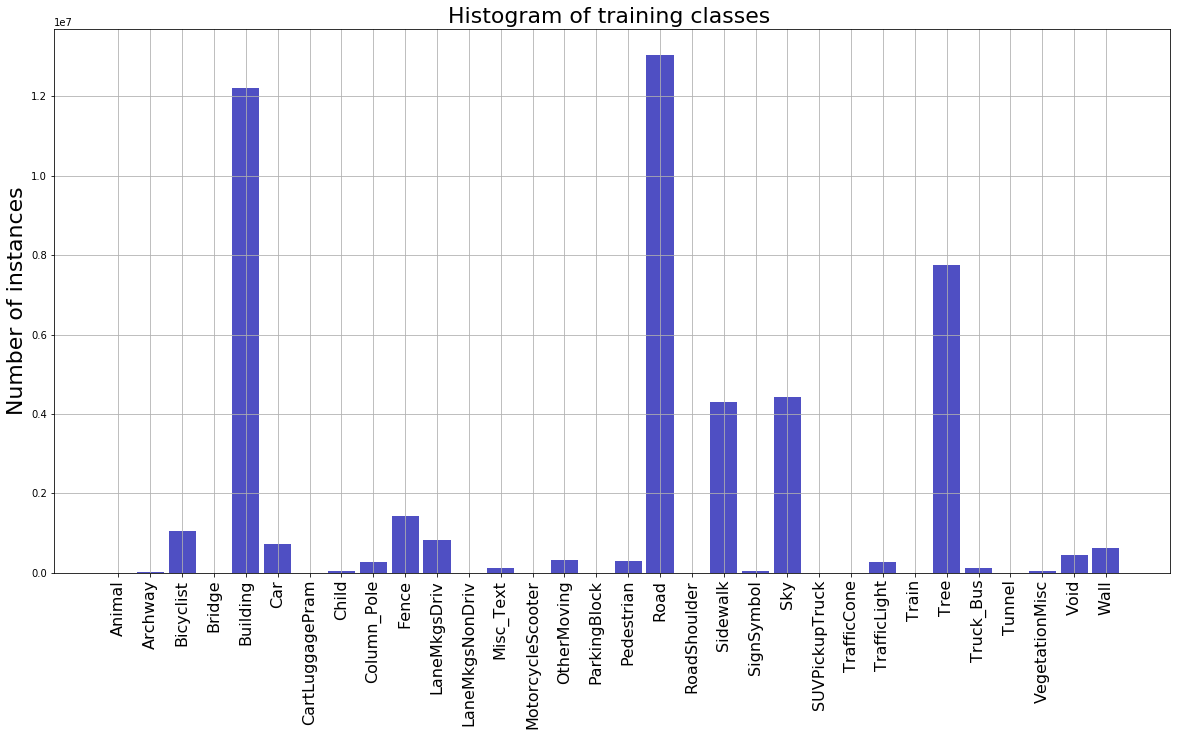

In [19]:
def plot_class_histogram(class_vec,dict_idx_class, n_classes):
    
    plt.figure(figsize=(20,10))
    m_bins = np.arange(n_classes+1) - 0.5
    n, bins, patches = plt.hist(class_vec, bins=m_bins, color='#0504aa',
                                alpha=0.7, rwidth=0.85)

    plt.title("Histogram of training classes ", fontsize=22)
    plt.grid('on')
    plt.ylabel("Number of instances", fontsize=22)

    xtick_labels = dict_idx_class.values()
#     print(xtick_labels)

    # # now, define the ticks (i.e. locations where the labels will be plotted)
    xticks = [i for i in range(n_classes)]

    # # also define the labels we'll use (note this MUST have the same size as `xticks`!)
    # xtick_labels = ['Family-%d' % (f+1) for f in range(NUM_FAMILIES)]

    ax = plt.gca()
    # add the ticks and labels to the plot
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels,fontsize=16, rotation=90)
    return n

n =plot_class_histogram(all_idx, dict_idx_class, n_classes)

### The classes are not equally represented. One way to account for this is to specify the class weights. This way, classes with lower representation get higher weights. This might improve some of the results.



Class Frequency:
[0.00000000e+00 2.93340774e-04 2.15439401e-02 0.00000000e+00
 2.52380477e-01 1.51882854e-02 1.05324074e-04 8.01277282e-04
 5.46455440e-03 2.95832713e-02 1.70185599e-02 2.06679894e-08
 2.55836640e-03 0.00000000e+00 6.86055308e-03 0.00000000e+00
 6.33548280e-03 2.69431713e-01 0.00000000e+00 8.88613385e-02
 6.78013393e-04 9.14449405e-02 0.00000000e+00 0.00000000e+00
 5.56653026e-03 0.00000000e+00 1.60047061e-01 2.71370701e-03
 0.00000000e+00 9.56721230e-04 9.20386905e-03 1.29626529e-02] 0.002636036706349206
Median: 0.006860553075396825
Simple class weight scheme. 
 All class frequencies less than median will be higher value and other values are another lower value
done
(32,)


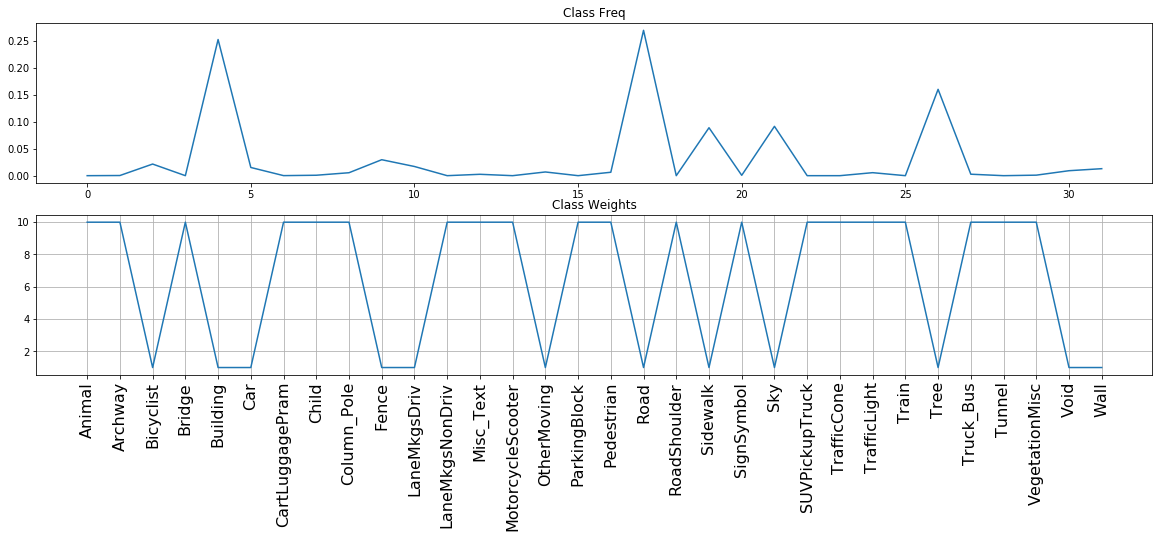

In [20]:
total_pixels = np.sum(n)
class_freq = n / total_pixels

# class_freq = np.copy(class_freq)
print("Class Frequency:")
print(class_freq, np.median(class_freq))
# print("\nSorted Class Freq:",np.sort(class_freq))
# print("Median: {}".format(np.median(class_freq)))

# Remove values that are 0
class_freq_nonzero = class_freq[class_freq !=0]

median_value = np.median(class_freq_nonzero)
# print("Nonzero Class Freq:",np.sort(class_freq_nonzero))
print("Median: {}".format(median_value))

# class_freq[class_freq<1e-10] = 0.1
# print("Class Frequency: {}".format(class_freq))

# Assign class weights
# class_weights = 10*np.median(class_freq_nonzero) / (class_freq + 1e-10)
# class_weights[class_weights>20]=  20
print("Simple class weight scheme. \n All class frequencies less than median will be higher value and other values are another lower value")
class_weights = np.zeros_like(class_freq)
class_weights[class_freq<median_value] = 10
class_weights[class_freq>=median_value] = 1


plt.figure(figsize=(20,10))
# plt.subplots(nrows=1,ncols=3)
plt.subplot(311)
plt.plot(class_freq)
plt.title("Class Freq")
plt.subplot(312)
plt.plot(class_weights)
plt.title("Class Weights")
plt.grid()

xtick_labels = dict_idx_class.values()
#     print(xtick_labels)

# # now, define the ticks (i.e. locations where the labels will be plotted)
xticks = [i for i in range(n_classes)]

# # also define the labels we'll use (note this MUST have the same size as `xticks`!)
# xtick_labels = ['Family-%d' % (f+1) for f in range(NUM_FAMILIES)]

ax = plt.gca()
# add the ticks and labels to the plot
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels,fontsize=16, rotation=90)

print("done")

print(class_weights.shape)
# # print("np.median(class_freq): {}".format(np.median(class_freq)))
# class_weights = np.median(class_freq) / (class_freq + 1e-10)

# class_weights[class_weights>20] = 0.5
# # print("Class Weights: {}".format(class_weights))


# plot_class_histogram(all_idx, dict_idx_class, n_classes)

# Create a dict for model.fit usage
dict_class_weights = {k:v for k,v in enumerate(class_weights)}

#Create the tensor of weights
tf_class_weights = tf.compat.v2.constant([class_weights.astype('float32')])



In [21]:

# total_pixels = np.sum(n)
# class_freq = n / total_pixels

# # print("np.median(class_freq): {}".format(np.median(class_freq)))
# class_weights = np.median(class_freq) / (class_freq + 1e-10)

# class_weights[class_weights>20] = 0.5

# # TRIAL ONLY: Set all class weights to be 1 for testin
# # class_weights[class_weights<1e10] =1

# # print("Class Weights: {}".format(class_weights))


# plot_class_histogram(all_idx, dict_idx_class, n_classes)

# # Plot the weights 
# # class_weights[class_weights>50] = np.median(class_weights)/4
# # print(class_weights)
# plt.figure(figsize=(20,10))
# plt.plot(class_weights)
# plt.grid()
# plt.title('Assigned Class Weights ')

# # # # now, define the ticks (i.e. locations where the labels will be plotted)
# # xticks = [i for i in range(n_classes)]
# xtick_labels = dict_idx_class.values()

# # # now, define the ticks (i.e. locations where the labels will be plotted)
# xticks = [i for i in range(n_classes)]

# # # also define the labels we'll use (note this MUST have the same size as `xticks`!)
# # xtick_labels = ['Family-%d' % (f+1) for f in range(NUM_FAMILIES)]

# ax = plt.gca()
# # add the ticks and labels to the plot
# ax.set_xticks(xticks)
# ax.set_xticklabels(xtick_labels,fontsize=16, rotation=90)




## U Net architecture 

Text(0.5, 1.0, 'U-Net architecture')

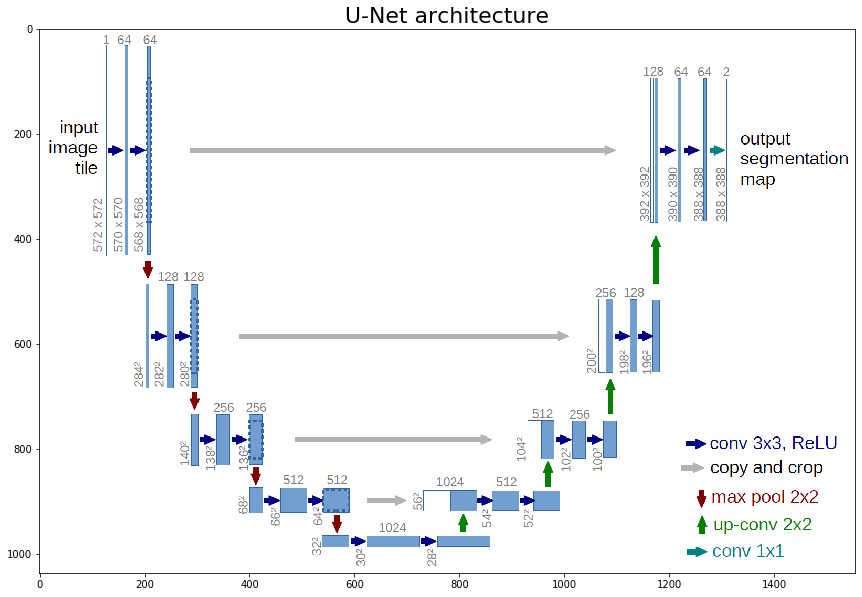

In [22]:
#Show the structure
img = plt.imread("../images/u-net-architecture.png")

plt.figure(figsize=(20,10))
plt.imshow(img)
plt.title("U-Net architecture", fontsize=22)

In [23]:
# Build the model using the functional API
def build_UNET(input_height = IMG_HEIGHT,input_width=IMG_WIDTH, input_channels= INPUT_CHANNELS, 
               n_classes = n_classes, 
               flag_use_bn=True,
               flag_use_dropout = False,
               DROPOUT_FRACTION= 0.2,
               flag_use_weighted_loss_fcn = False):

    #Encoder part
    #Block 1
    input_ = keras.layers.Input(shape=(input_height,input_width,input_channels))
#     c1 = keras.layers.Conv2D(16,kernel_size=(3,3) , kernel_initializer='he_normal', padding='same')(input_)
    c1 = keras.layers.Conv2D(16,kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(input_)
    
    if(flag_use_bn):
        # Apply BN before the activation
        c1 = keras.layers.BatchNormalization()(c1)
    c1 = keras.layers.Activation("relu")(c1)
        
    c1 = keras.layers.Conv2D(16,(3,3) , kernel_initializer='he_normal',padding='same')(c1)    
    if(flag_use_bn):
        # Apply BN before the activation
        c1 = keras.layers.BatchNormalization()(c1)
    c1 = keras.layers.Activation("relu")(c1)

    #Block 2
    p1 = keras.layers.MaxPool2D((2,2))(c1)
    if(flag_use_dropout):
        p1 = keras.layers.Dropout(DROPOUT_FRACTION)(p1)
    c2 = keras.layers.Conv2D(32,(3,3) , kernel_initializer='he_normal',padding='same')(p1)
    if(flag_use_bn):
        # Apply BN before the activation
        c2 = keras.layers.BatchNormalization()(c2)
    c2 = keras.layers.Activation("relu")(c2)

    c2 = keras.layers.Conv2D(32,(3,3) , kernel_initializer='he_normal',padding='same')(c2)
    if(flag_use_bn):
        # Apply BN before the activation
        c2 = keras.layers.BatchNormalization()(c2)
    c2 = keras.layers.Activation("relu")(c2)

    #Block 3
    p2 = keras.layers.MaxPool2D((2,2))(c2)
    if(flag_use_dropout):
        p2 = keras.layers.Dropout(DROPOUT_FRACTION)(p2)
    c3 = keras.layers.Conv2D(64,(3,3) , kernel_initializer='he_normal',padding='same')(p2)
    if(flag_use_bn):
        # Apply BN before the activation
        c3 = keras.layers.BatchNormalization()(c3)
    c3 = keras.layers.Activation("relu")(c3)

    c3 = keras.layers.Conv2D(64,(3,3) , kernel_initializer='he_normal',padding='same')(c3)
    if(flag_use_bn):
        # Apply BN before the activation
        c3 = keras.layers.BatchNormalization()(c3)
    c3 = keras.layers.Activation("relu")(c3)

    #Block 4
    p3 = keras.layers.MaxPool2D((2,2))(c3)
    if(flag_use_dropout):
        p3 = keras.layers.Dropout(DROPOUT_FRACTION)(p3)
        
    c4 = keras.layers.Conv2D(128,(3,3) , kernel_initializer='he_normal',padding='same')(p3)
    if(flag_use_bn):
        # Apply BN before the activation
        c4 = keras.layers.BatchNormalization()(c4)
    c4 = keras.layers.Activation("relu")(c4)

    c4 = keras.layers.Conv2D(128,(3,3) , kernel_initializer='he_normal',padding='same')(c4)
    if(flag_use_bn):
        # Apply BN before the activation
        c4 = keras.layers.BatchNormalization()(c4)
    c4 = keras.layers.Activation("relu")(c4)

    #Block 5
    p4 = keras.layers.MaxPool2D((2,2))(c4)
    if(flag_use_dropout):
        p4 = keras.layers.Dropout(DROPOUT_FRACTION)(p4)
    c5 = keras.layers.Conv2D(256,(3,3) , kernel_initializer='he_normal',padding='same')(p4)
    if(flag_use_bn):
        # Apply BN before the activation
        c5 = keras.layers.BatchNormalization()(c5)
    c5 = keras.layers.Activation("relu")(c5)

    c5 = keras.layers.Conv2D(256,(3,3) , kernel_initializer='he_normal',padding='same')(c5)
    if(flag_use_bn):
        # Apply BN before the activation
        c5 = keras.layers.BatchNormalization()(c5)
    c5 = keras.layers.Activation("relu")(c5)


    #Decoder part

    #Block 6
    u1 = keras.layers.Conv2DTranspose(128,(2,2), strides=(2,2) ,padding='same')(c5)
    u1 = keras.layers.concatenate([c4, u1])
    c6 = keras.layers.Conv2D(128,(3,3) , kernel_initializer='he_normal',padding='same')(u1)
    if(flag_use_bn):
        # Apply BN before the activation
        c6 = keras.layers.BatchNormalization()(c6)
    c6 = keras.layers.Activation("relu")(c6)


    c6 = keras.layers.Conv2D(128,(3,3) , kernel_initializer='he_normal',padding='same')(c6)
    if(flag_use_bn):
        # Apply BN before the activation
        c6 = keras.layers.BatchNormalization()(c6)
    c6 = keras.layers.Activation("relu")(c6)

    #Block 7
    u2 = keras.layers.Conv2DTranspose(64,(2,2), strides=(2,2), activation='relu',padding='same')(c6)
    u2 = keras.layers.concatenate([c3,u2])
    c7 = keras.layers.Conv2D(64,(3,3) , kernel_initializer='he_normal',padding='same')(u2)
    if(flag_use_bn):
        # Apply BN before the activation
        c7 = keras.layers.BatchNormalization()(c7)
    c7 = keras.layers.Activation("relu")(c7)

    c7 = keras.layers.Conv2D(64,(3,3) , kernel_initializer='he_normal',padding='same')(c7)
    if(flag_use_bn):
        # Apply BN before the activation
        c7 = keras.layers.BatchNormalization()(c7)
    c7 = keras.layers.Activation("relu")(c7)

    #Block 8
    u3 = keras.layers.Conv2DTranspose(32,(3,3), strides=(2,2), activation='relu',padding='same')(c7)
    u3 = keras.layers.concatenate([c2,u3])
    c8 = keras.layers.Conv2D(32,(3,3) , kernel_initializer='he_normal',padding='same')(u3)
    if(flag_use_bn):
        # Apply BN before the activation
        c8 = keras.layers.BatchNormalization()(c8)
    c8 = keras.layers.Activation("relu")(c8)

    c8 = keras.layers.Conv2D(32,(3,3) , kernel_initializer='he_normal',padding='same')(c8)
    if(flag_use_bn):
        # Apply BN before the activation
        c8 = keras.layers.BatchNormalization()(c8)
    c8 = keras.layers.Activation("relu")(c8)

    #Block 9
    u4 = keras.layers.Conv2DTranspose(16,(2,2), strides=(2,2), activation='relu',padding='same')(c8)
    u4 = keras.layers.concatenate([c1,u4])
    c9 = keras.layers.Conv2D(16,(3,3) , kernel_initializer='he_normal',padding='same')(u4)
    if(flag_use_bn):
        # Apply BN before the activation
        c9 = keras.layers.BatchNormalization()(c9)
    c9 = keras.layers.Activation("relu")(c9)

    c9 = keras.layers.Conv2D(16,(3,3) , kernel_initializer='he_normal',padding='same')(c9)
    if(flag_use_bn):
        # Apply BN before the activation
        c9 = keras.layers.BatchNormalization()(c9)
    c9 = keras.layers.Activation("relu")(c9)

    #Final layer
    # Softmax is using categorical cross entropy. Logits if using the custom loss function
    if(flag_use_weighted_loss_fcn):
        c10 = keras.layers.Conv2D(n_classes,(3,3),activation=None,padding='same',name='final_layer_for_custom_loss')(c9)
    else:
        c10 = keras.layers.Conv2D(n_classes,(3,3),activation='softmax',padding='same',name='final_layer_for_categ_xtropy')(c9)

    outputs = c10

    model = keras.Model(inputs=[input_],outputs=[outputs], name='U-Net')
    
    
    return model


In [24]:
model = build_UNET(input_height = IMG_HEIGHT,input_width=IMG_WIDTH, input_channels= INPUT_CHANNELS, 
               n_classes = n_classes, 
               flag_use_bn=True,
               flag_use_dropout = False,
               DROPOUT_FRACTION= 0.2,
               flag_use_weighted_loss_fcn =flag_use_weighted_loss_fcn)

model.summary()



Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

activation_10 (Activation)      (None, 32, 32, 128)  0           batch_normalization_10[0][0]     
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 32, 128)  147584      activation_10[0][0]              
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 32, 32, 128)  512         conv2d_11[0][0]                  
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 32, 32, 128)  0           batch_normalization_11[0][0]     
__________________________________________________________________________________________________
conv2d_transpose_1 (Conv2DTrans (None, 64, 64, 64)   32832       activation_11[0][0]              
__________________________________________________________________________________________________
concatenat

In [25]:
# Plot the model
try:
    tf.keras.utils.plot_model(model,show_shapes=True)
except Exception as ex:
    print(ex)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [26]:
model_folder_name = "unet_camvid"
model_name = model_folder_name + ".h5"


#ModelCheckpoint - Save only the best model
save_model_filepath = os.path.join(os.path.abspath(os.pardir),"models",model_folder_name,model_name)

print("ModelCheckpoint Callback saves the model in: {}".format(save_model_filepath))

checkpoint_cb = keras.callbacks.ModelCheckpoint(save_model_filepath,
                                               save_best_only=True)

# Early stopping.
# ModelCheckpoint will save best, but wont stop training, which might go on for a long time and consume resources.
# Early stoppoing callback helps with this
# early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                      patience=10,
#                                                      restore_best_weights=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=50,
                                                  restore_best_weights=True)

#Create a custom callback if needed. For example, display the ratio of validation loss / training_loss to detect overfitting
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        if(epoch%5==0):
#             print(logs.keys())
            print( "Custom Callback - ")
            print("\nEpoch: {:.2f}, train_acc: {:.2f}, val_acc= {:.2f}, train_loss= {:.2f}, val_loss = {:.2f}".format\
                  (epoch,logs["accuracy"],logs["val_accuracy"],logs["loss"],logs["val_loss"]))
            print("train_dice_coeff = {:.2f}, val_dice_coeff = {:.2f}".format(logs["dice_coef"] , logs["val_dice_coef"]))
#             print("val/train loss ratio: {:.2f}".format(epoch, logs["val_loss"] / logs["loss"]))

   
# #Instance of the custom callback
# print_ratio_cb = PrintValTrainRatioCallback()

#Tensorboard callback

#Note:
#For windows, forward and back slahses are painful to get right for the tensorboard usage.
# What works is that create a windows path, and replace the \ with \\

#Save data in models folder.
root_logdir = os.path.join(os.pardir, "models", model_folder_name, "tensorboard", "my_logs")
print("Tensorboard parent logs folder: {}".format(root_logdir))

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    return os.path.join(root_logdir,run_id)

run_logdir = get_run_logdir()
print("Current logdir: {}".format(run_logdir))

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)



def show_onehot_predictions(im_array,mask_array):
    pred_intermediate = model.predict(im_array)
    for i in range(pred_intermediate.shape[0]):
        fig = plt.figure(figsize=(20,8))

        ax1 = fig.add_subplot(1,3,1)
        ax1.imshow(im_array[i])
        ax1.title.set_text('Actual frame')
        ax1.grid(b=None)


        ax2 = fig.add_subplot(1,3,2)
        ax2.set_title('Ground truth labels')
        ax2.imshow(onehot_to_rgb(mask_array[i],dict_idx_rgb))
        ax2.grid(b=None)

        ax3 = fig.add_subplot(1,3,3)
        ax3.set_title('Predicted labels')

        ax3.imshow(onehot_to_rgb(pred_intermediate[i],dict_idx_rgb))
        ax3.grid(b=None)

        plt.show()

    
    
    
# Show Segmentation result during the training
class display_prediction_callback(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        if(epoch%20==0):            
            # Get some images:
            im_array, mask_array = next(ValidationDataGenerator(batch_size=1))
            show_onehot_predictions(im_array, mask_array)

        
# callbacks=[checkpoint_cb,early_stopping_cb, tensorboard_cb]#, display_prediction_callback()]
callbacks=[checkpoint_cb, tensorboard_cb,early_stopping_cb,PrintValTrainRatioCallback()]
# callbacks=[checkpoint_cb, tensorboard_cb,PrintValTrainRatioCallback()]


ModelCheckpoint Callback saves the model in: C:\Users\abhat\research\Tensorflow_2.0_tutorials\models\unet_camvid\unet_camvid.h5
Tensorboard parent logs folder: ..\models\unet_camvid\tensorboard\my_logs
Current logdir: ..\models\unet_camvid\tensorboard\my_logs\run_2020_03_19_01_50_32


## Dice Loss 

In [27]:
# Ref: salehi17, "Twersky loss function for image segmentation using 3D FCDN"
# -> the score is computed for each class separately and then summed
# alpha=beta=0.5 : dice coefficient
# alpha=beta=1   : tanimoto coefficient (also known as jaccard)
# alpha+beta=1   : produces set of F*-scores
# implemented by E. Moebel, 06/04/18
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

In [28]:
# Create Dice loss
def dice_coef(y_true, y_pred):
    
    if(flag_use_weighted_loss_fcn):
        # The output of the model in this case are logits, not he softmax output. 
        # Hence, y_pred needs to be passed throug a softmax before calculating the dice_loss
        y_pred = tf.nn.softmax(y_pred,axis = -1)
        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

smooth =1.0

### Define custom loss for the weighted softmax 

In [29]:
def weighted_softmax_cross_entropy_with_logits(one_hot_labels,y_pred_logits):
    '''
    reference: https://stackoverflow.com/questions/44560549/unbalanced-data-and-weighted-cross-entropy
    '''
    
#     print("one_hot_labels.shape",one_hot_labels.shape)
#     print("y_pred_logits.shape",y_pred_logits.shape)
    
    # Create a custom loss with weights 
    # your class weights
    # Already defined when defining the weight
#     tf_class_weights = tf.compat.v2.constant([class_weights.astype('float32')])

#     print("tf_class_weights: ", tf_class_weights)
    # deduce weights for batch samples based on their true label
    weights = tf.compat.v2.reduce_sum(tf_class_weights *one_hot_labels, axis=-1)
#     print("weights.shape: {}".format(weights.shape))
#     print("weights.dtype: {}".format(weights.dtype))

    # compute your (unweighted) softmax cross entropy loss
    unweighted_losses = tf.compat.v2.nn.softmax_cross_entropy_with_logits(one_hot_labels, y_pred_logits)
    # print(unweighted_losses)

#     print(unweighted_losses.dtype, weights.dtype)
    # apply the weights, relying on broadcasting of the multiplication
    weighted_losses = unweighted_losses * weights
#     print(weighted_losses[0][0])
#     plt.figure()
#     plt.plot(weighted_losses[0][0])
#     print("weighted_losses.shape:",weighted_losses.shape)
    
    # reduce the result to get your final loss
    loss = tf.reduce_mean(weighted_losses)
    
    return loss


# im_array = test_batch[0]
# onehot_array = test_batch[1]

m_batch = TrainingDataGenerator()
test_batch = next(m_batch)
im_array = test_batch[0]
onehot_array = test_batch[1]

y_pred_logits = model.predict(im_array)

loss = weighted_softmax_cross_entropy_with_logits(onehot_array,y_pred_logits)
print(loss)

In TrainingDataGenerator 
Initializing  TrainingDataGenerator 
Found 70 images belonging to 1 classes.
Found 70 images belonging to 1 classes.
tf.Tensor(4.2454176, shape=(), dtype=float32)


In [30]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
if flag_use_weighted_loss_fcn:
    
    model.compile(optimizer=optimizer,
                  loss=weighted_softmax_cross_entropy_with_logits,
                  metrics=[dice_coef,'accuracy'])

else:
    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=[dice_coef,'accuracy'])

In [31]:
batch_size = 15

# For each test image I am taking a cropping of the dat,a hence many crops can be made for each image.
# This should help withcreating additional data
crop_multiplier = 3
steps_per_epoch = np.floor(num_training_samples / batch_size)  * crop_multiplier

steps_per_epoch

12.0

In [32]:
validation_steps = np.floor(num_validation_samples /batch_size) * crop_multiplier
validation_steps

6.0

In [33]:
num_epochs = 200

In [34]:
if flag_train_model:
    
#     batch_size = 5
    result = model.fit_generator(TrainingDataGenerator(batch_size=batch_size),
                                 steps_per_epoch=steps_per_epoch ,
                                 validation_data = ValidationDataGenerator(batch_size=batch_size), 
                                 validation_steps = validation_steps,
                                 epochs=num_epochs,
                                 verbose=0,
                                 callbacks=callbacks)

else:
    model = keras.models.load_model('../models/unet_camvid/unet_camvid.h5',
                                   custom_objects={"dice_coef": dice_coef})
    
# model.save_weights("camvid_model_150_epochs.h5", overwrite=True)

W0319 01:50:36.931015 20632 deprecation.py:323] From <ipython-input-34-38f6ae9b15fe>:10: Model.fit_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.fit, which supports generators.


In TrainingDataGenerator 
Initializing  TrainingDataGenerator 
Found 70 images belonging to 1 classes.
Found 70 images belonging to 1 classes.


W0319 01:50:39.111205 20632 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


In ValidationDataGenerator 
Initializing  ValidationDataGenerator 
Found 31 images belonging to 1 classes.
Found 31 images belonging to 1 classes.


W0319 01:50:41.164246 20632 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Custom Callback - 

Epoch: 0.00, train_acc: 0.47, val_acc= 0.14, train_loss= 2.43, val_loss = 2.66
train_dice_coeff = 0.19, val_dice_coeff = 0.24
Custom Callback - 

Epoch: 5.00, train_acc: 0.72, val_acc= 0.25, train_loss= 0.89, val_loss = 3.33
train_dice_coeff = 0.77, val_dice_coeff = 0.29
Custom Callback - 

Epoch: 10.00, train_acc: 0.79, val_acc= 0.48, train_loss= 0.64, val_loss = 2.14
train_dice_coeff = 0.84, val_dice_coeff = 0.53
Custom Callback - 

Epoch: 15.00, train_acc: 0.81, val_acc= 0.47, train_loss= 0.55, val_loss = 2.83
train_dice_coeff = 0.86, val_dice_coeff = 0.51
Custom Callback - 

Epoch: 20.00, train_acc: 0.82, val_acc= 0.53, train_loss= 0.50, val_loss = 2.08
train_dice_coeff = 0.87, val_dice_coeff = 0.58
Custom Callback - 

Epoch: 25.00, train_acc: 0.83, val_acc= 0.35, train_loss= 0.47, val_loss = 3.63
train_dice_coeff = 0.87, val_dice_coeff = 0.41
Custom Callback - 

Epoch: 30.00, train_acc: 0.87, val_acc= 0.83, train_loss= 0.33, val_loss = 0.48
train_dice_coeff = 0

In [35]:
# if flag_train_model:
#     print(result.history)


dict_keys(['loss', 'dice_coef', 'accuracy', 'val_loss', 'val_dice_coef', 'val_accuracy'])
(3,)


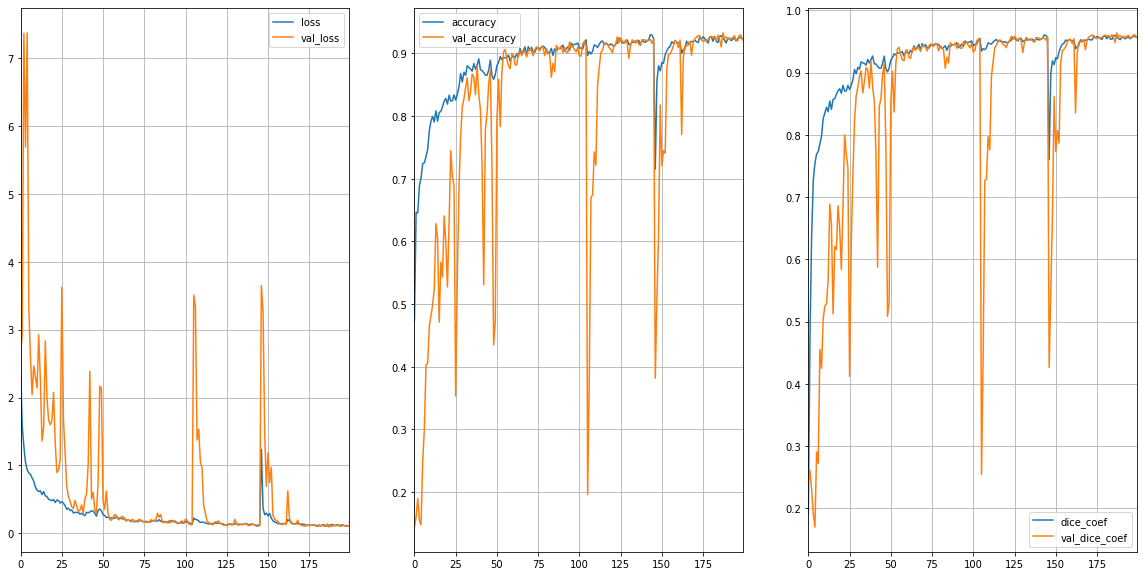

In [36]:
# Plot the history only if training was done

if flag_train_model:
    
    # Plot the history
    import pandas as pd

    print(result.history.keys())
    
    df = pd.DataFrame(result.history)
        
    fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,10))
    
    labels_to_plot = [['loss','val_loss'], ['accuracy','val_accuracy'],['dice_coef','val_dice_coef']]
    print(axes.shape)
    
    for idx,mx in enumerate(axes):
        df.plot(y=labels_to_plot[idx],ax = mx)
        
        # Enable grid on all subplots
        mx.grid(True)
            
    # plt.gca().set_ylim(0,10)

In [47]:
testing_gen = ValidationDataGenerator(batch_size=batch_size)



In [48]:
batch_img,batch_mask = next(testing_gen)
pred_all= model.predict(batch_img)
np.shape(pred_all)

In ValidationDataGenerator 
Initializing  ValidationDataGenerator 
Found 31 images belonging to 1 classes.
Found 31 images belonging to 1 classes.


(15, 256, 256, 32)

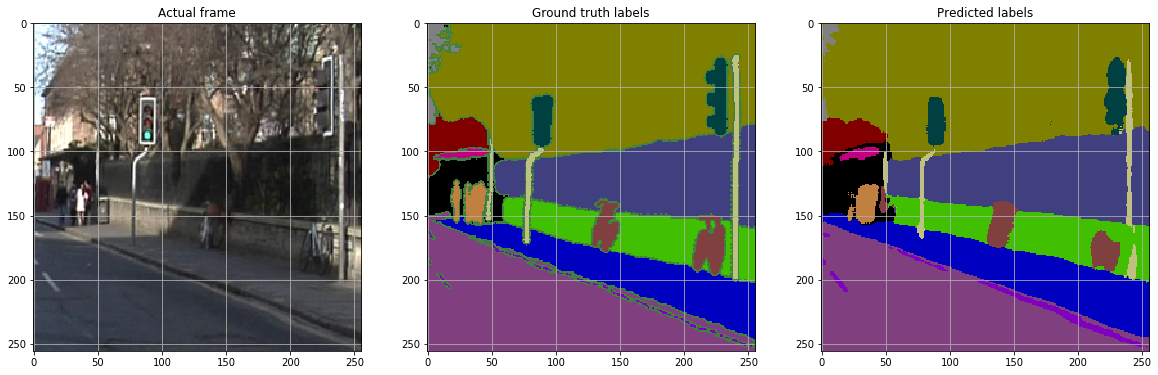

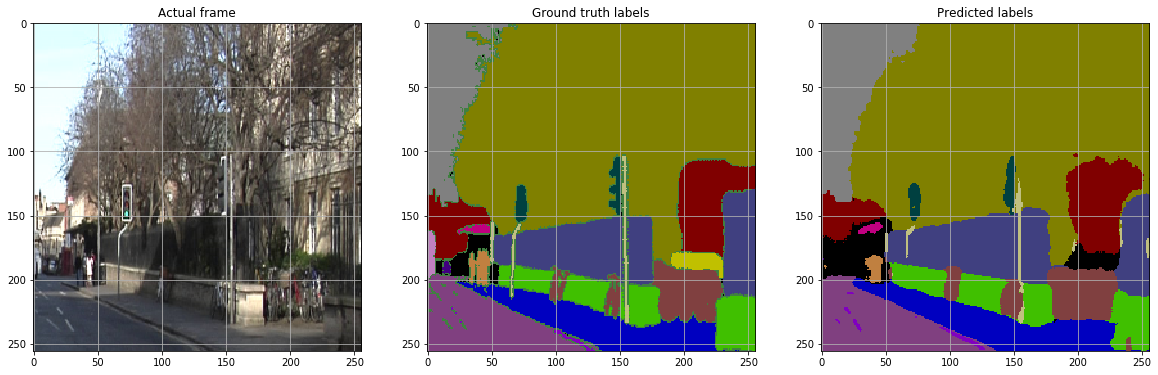

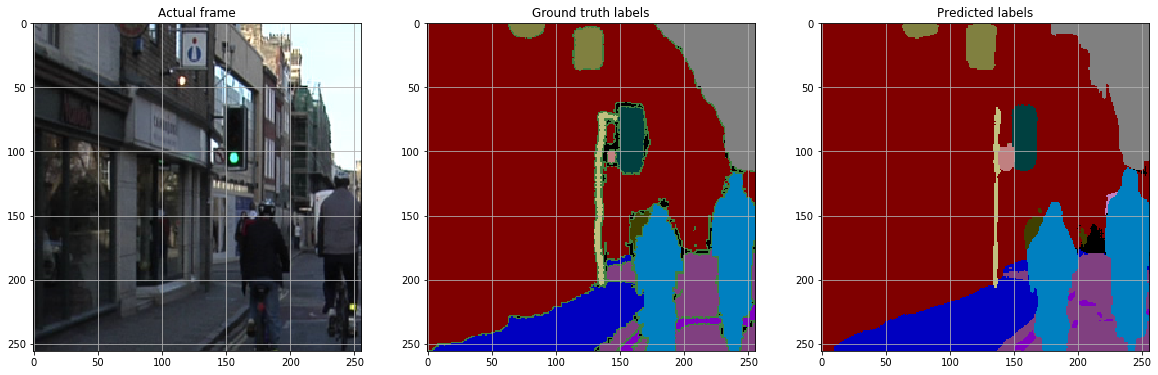

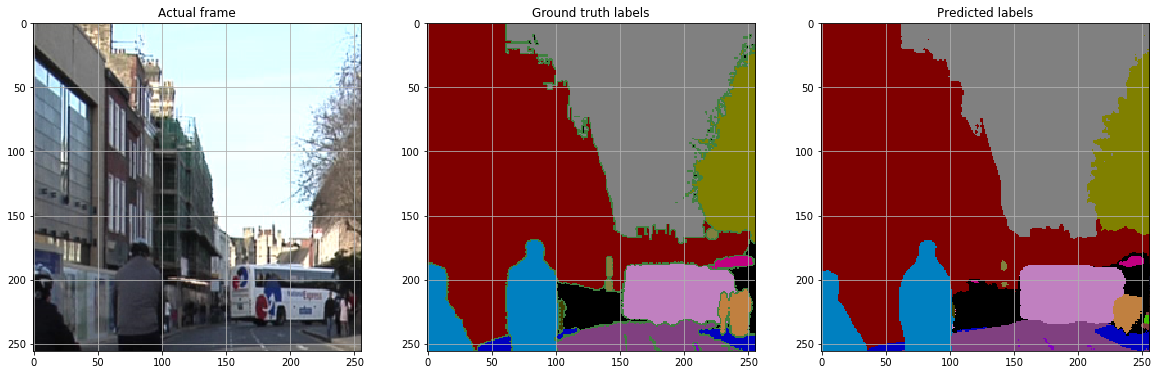

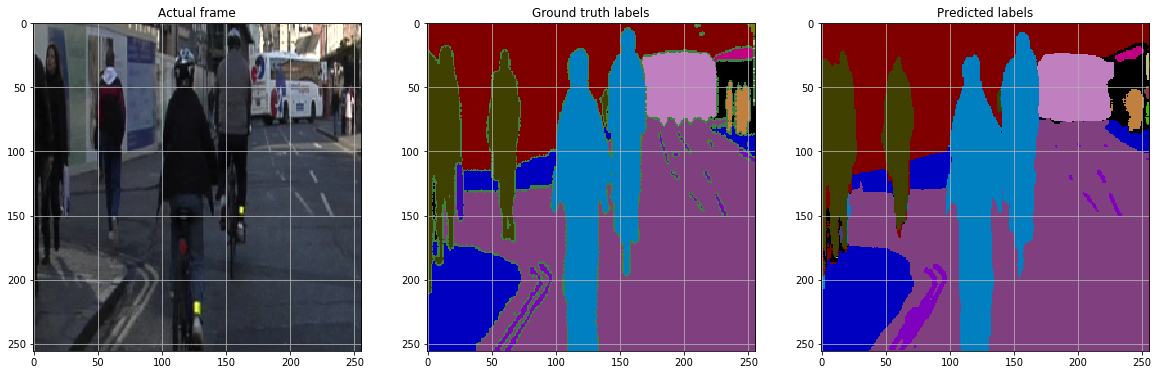

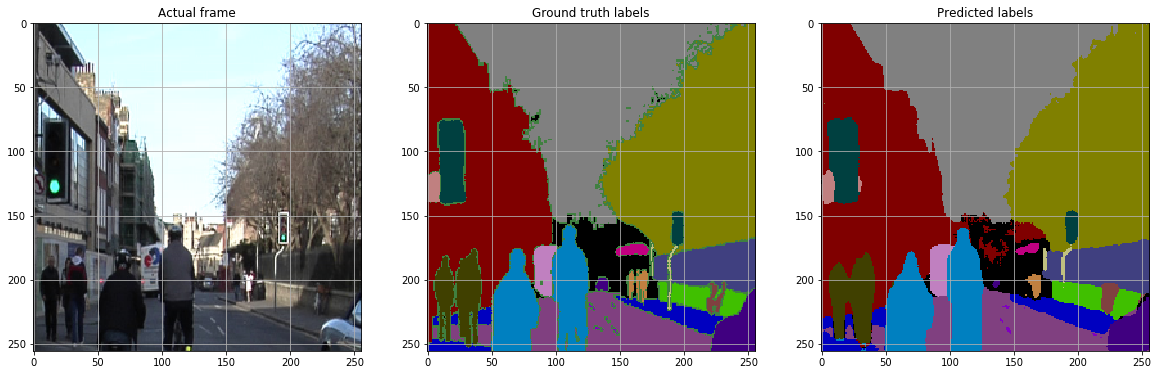

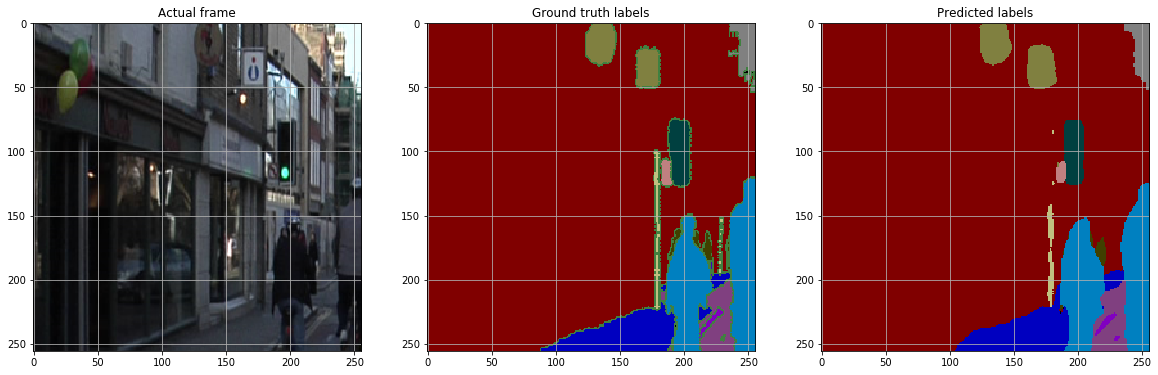

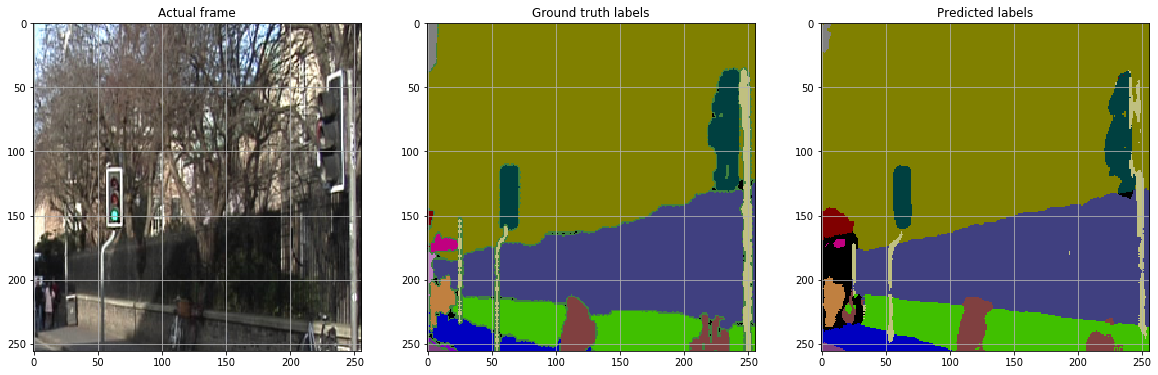

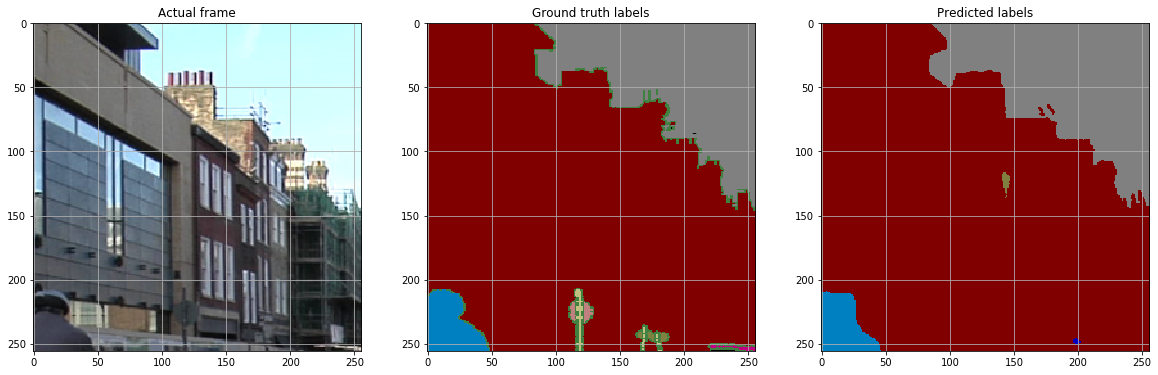

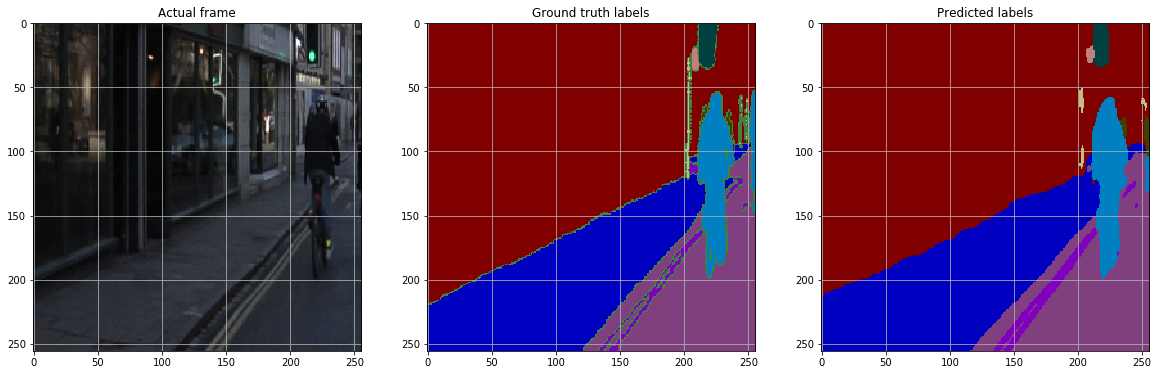

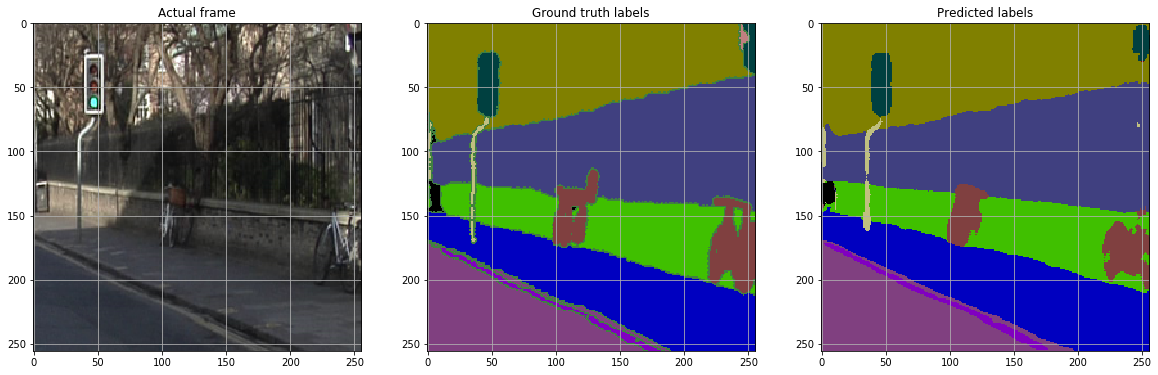

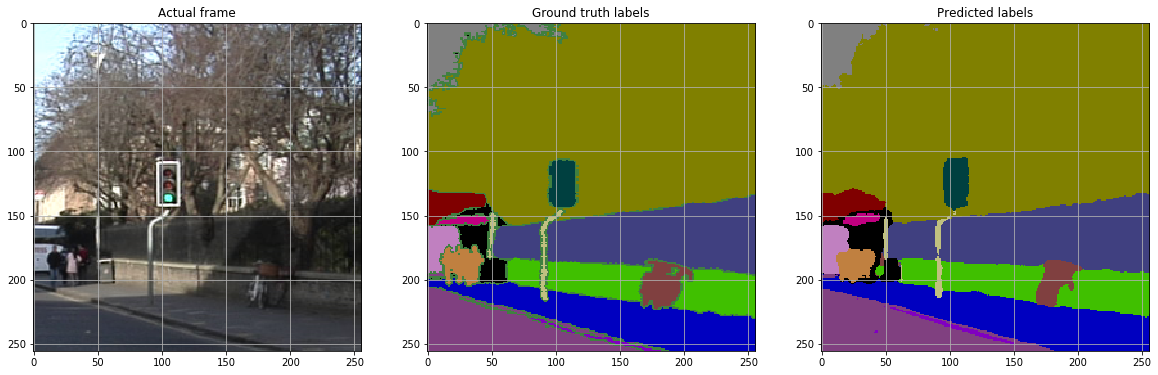

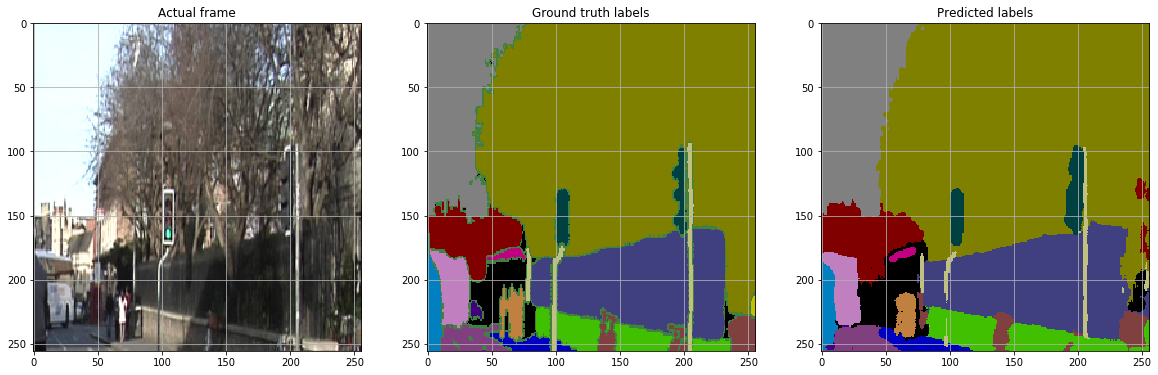

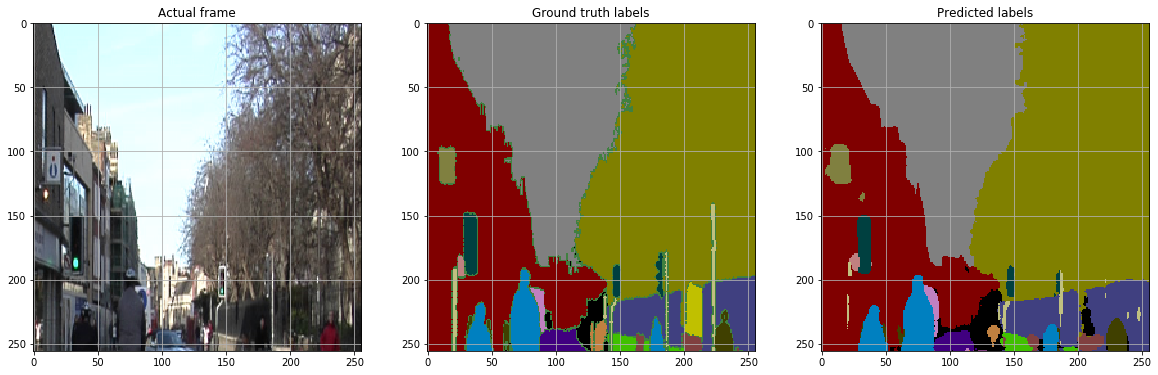

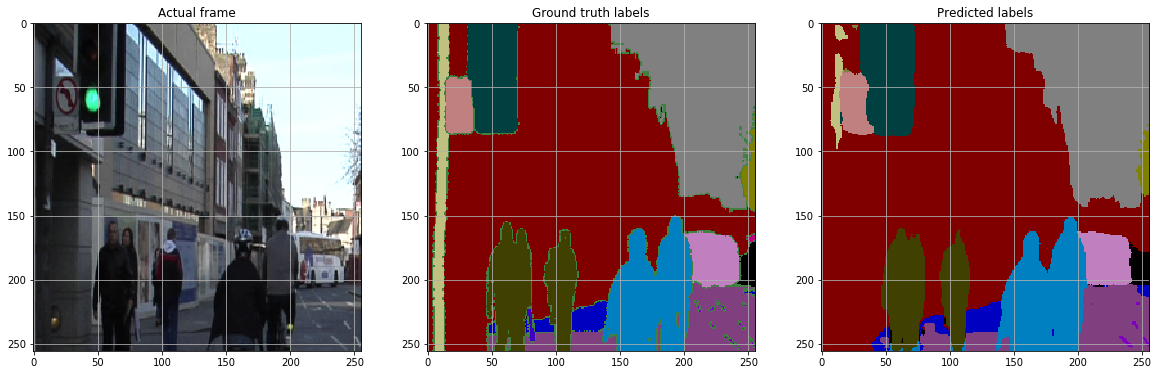

In [49]:
pred_all.shape

show_onehot_predictions(batch_img,batch_mask)


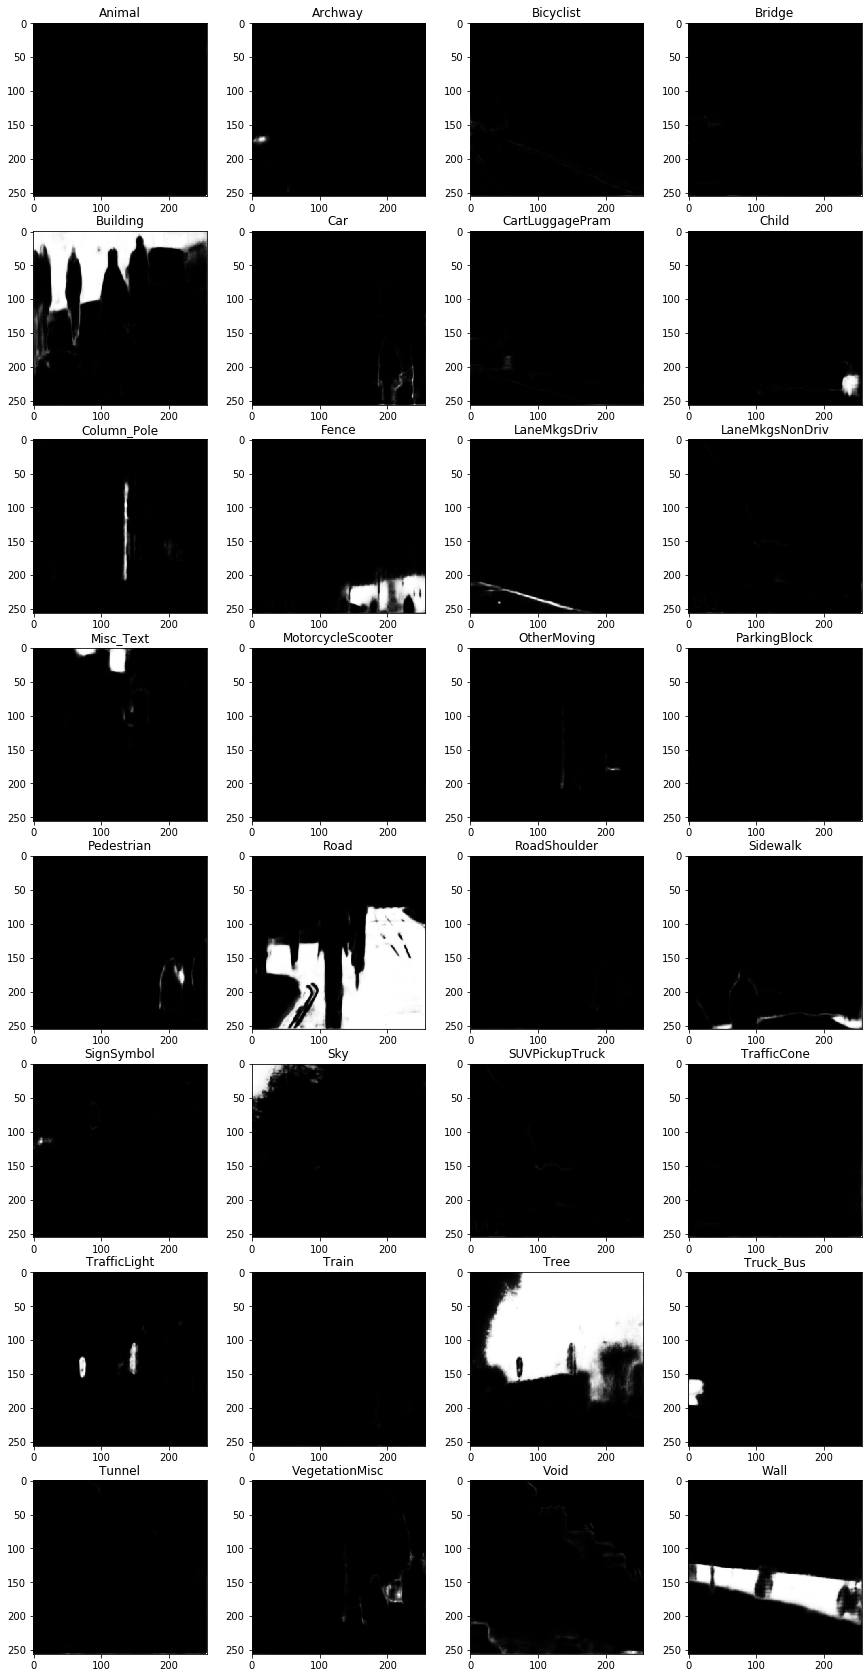

In [52]:
# out = onehot_to_rgb(pred_all[0],dict_idx_rgb)
# out.shape

# Show the individual channels for one of the images. Each channel represents a single class

plt.figure(figsize=(15,30))

for i in range(32):
    plt.subplot(8,4,i+1)
    if(flag_use_weighted_loss_fcn):
        # The output of the model in this case are logits, not he softmax output. 
        # Hence, y_pred needs to be passed throug a softmax before calculating the dice_loss
        y_pred = tf.nn.softmax(pred_all[np.random.randint(0,batch_size),:,:,i],axis = -1)

    else:
        y_pred = pred_all[np.random.randint(0,batch_size),:,:,i]
        
    plt.imshow(y_pred, cmap='gray')
    plt.title(dict_idx_class[i])
    
    

In TestDataGenerator 
Initializing TestDataGenerator 
Found 31 images belonging to 1 classes.
Found 31 images belonging to 1 classes.
out_onehot_batch_masks.shape:  (5, 256, 256, 32)
out_current_batch_frames.shape:  (5, 256, 256, 3)
out_current_batch_masks.shape:  (5, 256, 256, 3)


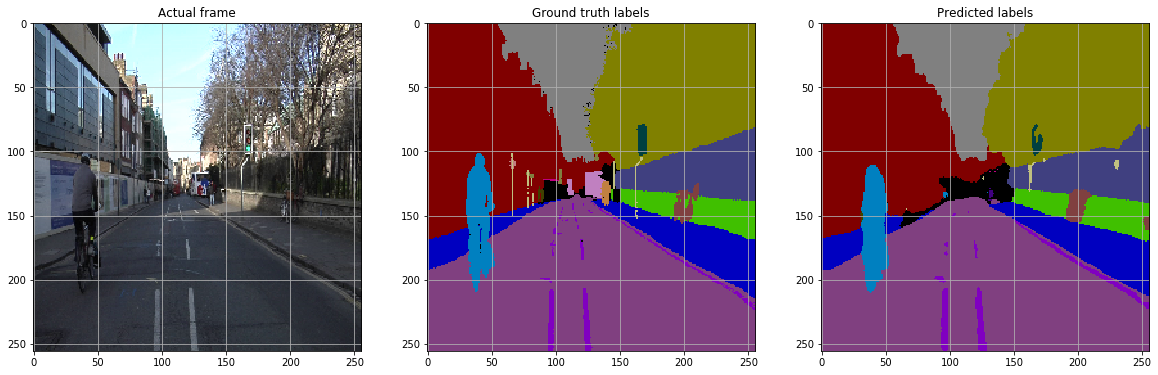

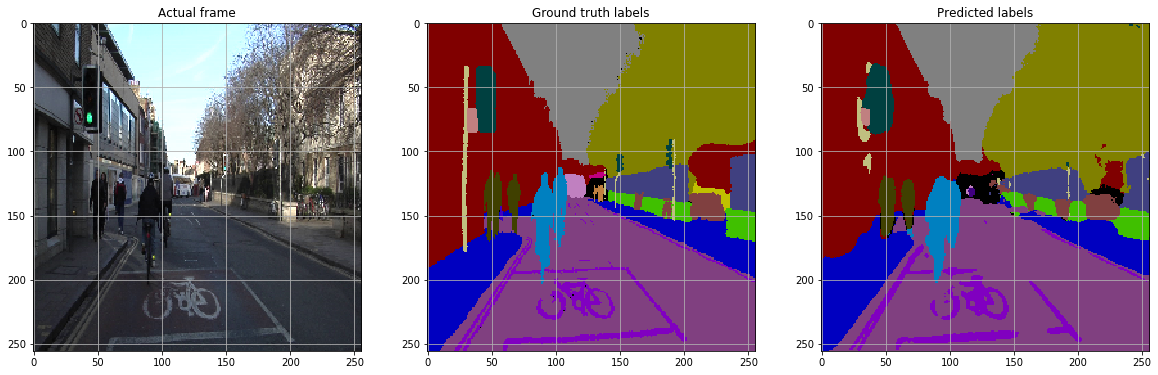

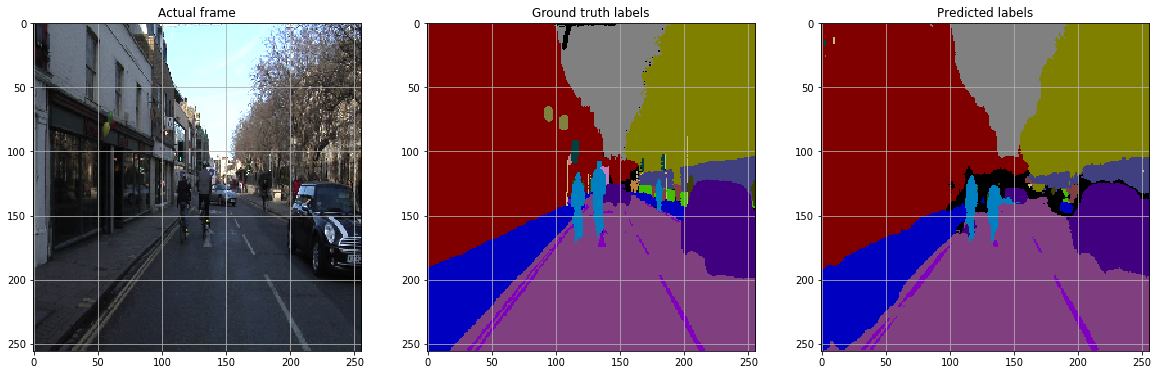

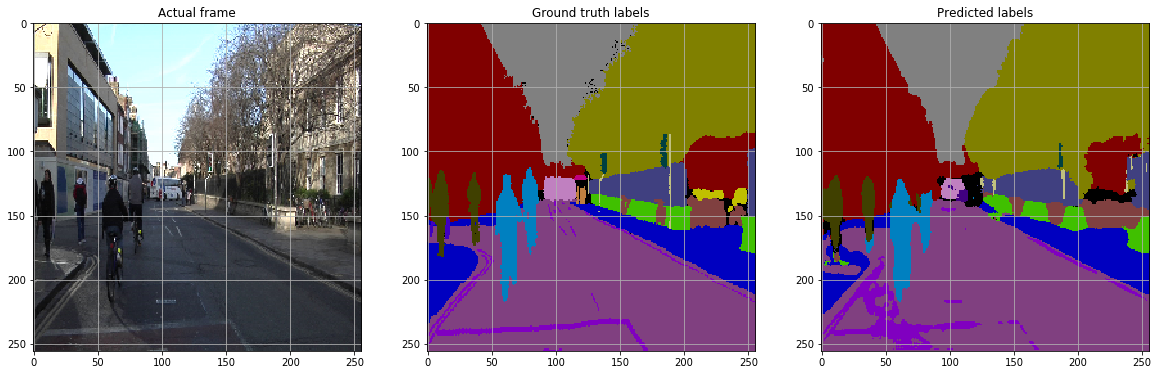

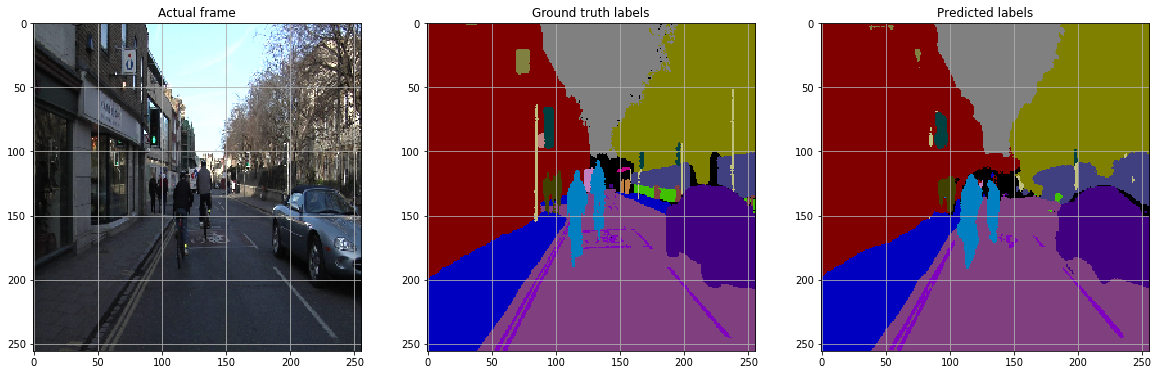

In [44]:
testing_gen = TestDataGenerator()

batch_img,batch_mask = next(testing_gen)
pred_all= model.predict(batch_img)
np.shape(pred_all)


# plt.imshow(img)

# # print(img)
# img_batch = tf.expand_dims(img,axis=0)

# print(img_batch.shape)
# pred_all= model.predict(img_batch)
# np.shape(pred_all)



# plt.figure
# plt.imshow(current_batch_masks[0])

show_onehot_predictions(batch_img,batch_mask)